In [1]:
%load_ext autoreload
%autoreload 2

## Standard libraries
import os
import json
import math
import random
import pickle 

# 3rd party libraries
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
CUDA_LAUNCH_BLOCKING=1

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from torchvision import transforms as transforms

# our own modules
from model import get_model, load_model, test_model
from ATSDS import ATSDS

In [2]:
# Define transformations for the train and test dataset
transform_train = transforms.Compose(
    [transforms.Resize(256),
    transforms.RandomCrop(size=(224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

transform_test = transforms.Compose(
    [transforms.Resize(256),
    transforms.CenterCrop(size=(224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Define paths using os.path.join for better cross-platform compatibility
DATASET_PATH = os.path.join("data", "auswertung_hpc", "auswertung")
MODEL_NAME = "convnext_tiny"
XAI_NAME = "gradcam"
ADV_PCT = "10"
dataset_type = os.path.join("occlusion", "10")
dataset_split = "test"
ROOT_PATH = os.path.join(DATASET_PATH, MODEL_NAME, XAI_NAME)

CHECKPOINT_PATH = "model/"
RANDOM_SEED = 1414


In [4]:
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Used for reproducability to fix randomness in some GPU calculations
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

testset = ATSDS(root=ROOT_PATH, split=dataset_split, dataset_type=dataset_type, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)


Using device cuda:0
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\10\test


In [5]:
model = get_model(model_name = MODEL_NAME, n_classes = testset.get_num_classes())
model = model.to(device)
loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,200)

epoch,trainstats = load_model(model, optimizer, scheduler, CHECKPOINT_PATH + MODEL_NAME + "_1_1.tar")
train_loss = trainstats[0]
test_loss = trainstats[1]
train_stats= trainstats[2]

# xai_methods = ["gradcam","ig_fixpoints","lime","prism","xrai"]
xai_methods = ["gradcam"]

performance_xai_type = {}


In [7]:

for current_method in xai_methods:
    ROOT_PATH = os.path.join(DATASET_PATH, MODEL_NAME, current_method)
    c_list = []
    c_5_list = []
    softmaxes_list = []
    scores_list = []
    losses = []
    
    # Iterate over occlusion percentages
    for pct in range(10,101,10):
        dataset_type = os.path.join("occlusion", str(pct)) 
        testset = ATSDS(root=ROOT_PATH, split=dataset_split, dataset_type=dataset_type, transform=transform_test)
        testloader = torch.utils.data.DataLoader(testset, batch_size = 1, shuffle = True, num_workers = 2)
        c,c_5,t,loss,softmaxes,scores = test_model(model,testloader,loss_criterion, device)
        c_list.append(c)
        c_5_list.append(c_5)
        softmaxes_list.append(softmaxes)
        scores_list.append(scores)
    performance_xai_type[current_method] = (c_list,c_5_list,softmaxes_list,scores_list,losses)
    
total = t


data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\10\test
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\20\test
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\30\test
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\40\test
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\50\test
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\60\test
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\70\test
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\80\test
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\90\test
data\auswertung_hpc\auswertung\convnext_tiny\gradcam\occlusion\100\test


In [9]:
# Save the performance_xai_type dictionary to a pickle file
dic_save_path = os.path.join(DATASET_PATH, MODEL_NAME, "occ_results.pkl")
with open(dic_save_path, 'wb') as f:
    pickle.dump(performance_xai_type, f)


In [10]:
# Load the performance_xai_type dictionary from the pickle file
dic_load_path = os.path.join(DATASET_PATH, MODEL_NAME, "occ_results.pkl")
with open(dic_load_path, 'rb') as f:
    performance_xai_type = pickle.load(f)


In [11]:
accuracies = []
for current_method in xai_methods:
    correct,correct_5,softmax,score,loss = performance_xai_type[current_method]
    accuracy = np.mean((np.divide(correct,50)),axis=1)
    accuracies.append(accuracy)

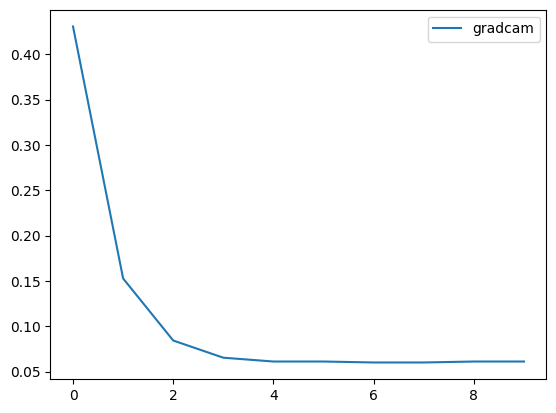

In [12]:
for i,entry in enumerate(accuracies):
    plt.plot(entry)
    plt.legend(xai_methods)

In [10]:
print(accuracies)

[array([0.97578947, 0.92631579, 0.88105263, 0.84105263, 0.82210526,
       0.79684211, 0.78842105, 0.77473684, 0.76210526, 0.75578947,
       0.74736842]), array([0.97578947, 0.32526316, 0.19789474, 0.13473684, 0.10315789,
       0.07789474, 0.06631579, 0.06315789, 0.06210526, 0.05684211,
       0.05473684]), array([0.97578947, 0.65368421, 0.43578947, 0.31368421, 0.21157895,
       0.15789474, 0.12210526, 0.09789474, 0.08631579, 0.07684211,
       0.07157895]), array([0.97578947, 0.90736842, 0.87052632, 0.84105263, 0.80210526,
       0.76526316, 0.73789474, 0.70631579, 0.67368421, 0.64736842,
       0.61684211]), array([0.97578947, 0.38210526, 0.23263158, 0.14736842, 0.11157895,
       0.08947368, 0.07473684, 0.06631579, 0.06631579, 0.06526316,
       0.06210526])]


In [11]:
print(xai_methods)

['gradcam', 'ig_fixpoints', 'lime', 'prism', 'xrai']


In [12]:
performance_xai_resnet = pickle.load(open(DATASET_PATH + "resnet50" + "occ_results.pkl", 'rb'))
performance_xai_convnext_tiny = pickle.load(open(DATASET_PATH + "convnext_tiny" + "occ_results.pkl", 'rb'))
performance_xai_simple_cnn = pickle.load(open(DATASET_PATH + "simple_cnn" + "occ_results.pkl", 'rb'))
performance_xai_vgg16 = pickle.load(open(DATASET_PATH + "vgg16" + "occ_results.pkl", 'rb'))
perf_tables = [performance_xai_simple_cnn,performance_xai_vgg16,performance_xai_resnet,performance_xai_convnext_tiny]
perf_tables_CNNs = ["Simple CNN", "VGG16", "ResNet50", "ConvNeXt-T"]

In [13]:
accuracies_all = []
for performance_xai_type in perf_tables:
    accuracies = []
    for current_method in xai_methods:
        print(current_method)
        correct,correct_5,softmax,score,loss = performance_xai_type[current_method]
        accuracy = np.mean((np.divide(correct,50)),axis=1)
        accuracies.append(accuracy)
    accuracies_all.append(accuracies)

gradcam
ig_fixpoints
lime
prism
xrai
gradcam
ig_fixpoints
lime
prism
xrai
gradcam
ig_fixpoints
lime
prism
xrai
gradcam
ig_fixpoints
lime
prism
xrai


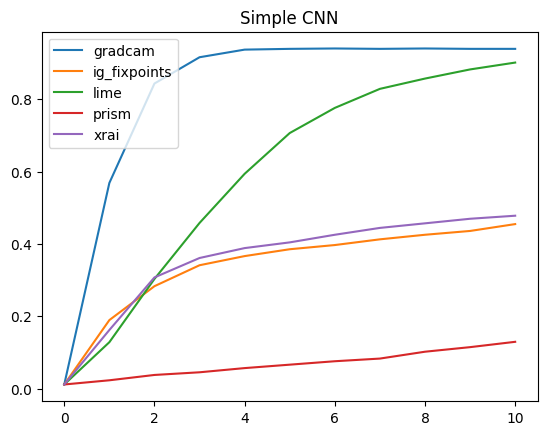

[array([0.98842105, 0.43157895, 0.15684211, 0.08421053, 0.06315789,
       0.06105263, 0.06      , 0.06105263, 0.06      , 0.06105263,
       0.06105263]), array([0.98842105, 0.81052632, 0.71684211, 0.65894737, 0.63368421,
       0.61473684, 0.60315789, 0.58736842, 0.57473684, 0.56421053,
       0.54526316]), array([0.98842105, 0.87157895, 0.69684211, 0.54210526, 0.40631579,
       0.29368421, 0.22421053, 0.17157895, 0.14315789, 0.11789474,
       0.09894737]), array([0.98842105, 0.97684211, 0.96210526, 0.95473684, 0.94315789,
       0.93368421, 0.92421053, 0.91684211, 0.89789474, 0.88526316,
       0.87052632]), array([0.98842105, 0.83789474, 0.69263158, 0.63894737, 0.61157895,
       0.59578947, 0.57473684, 0.55578947, 0.54315789, 0.53052632,
       0.52210526])]


In [14]:
for entry in accuracies_all[0]:
    plt.plot(1-entry)
plt.legend(xai_methods)
plt.title('Simple CNN')
plt.show()
print(accuracies_all[0])

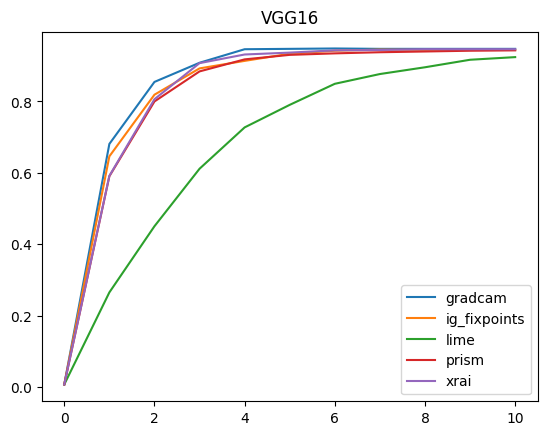

[array([0.99263158, 0.31894737, 0.14526316, 0.09157895, 0.05368421,
       0.05263158, 0.05157895, 0.05263158, 0.05263158, 0.05263158,
       0.05263158]), array([0.99263158, 0.35368421, 0.18105263, 0.10736842, 0.08631579,
       0.06631579, 0.05789474, 0.05473684, 0.05578947, 0.05578947,
       0.05578947]), array([0.99263158, 0.73473684, 0.54947368, 0.38842105, 0.27263158,
       0.20947368, 0.15052632, 0.12315789, 0.10421053, 0.08315789,
       0.07578947]), array([0.99263158, 0.40947368, 0.2       , 0.11578947, 0.08210526,
       0.06947368, 0.06526316, 0.06210526, 0.06      , 0.05789474,
       0.05684211]), array([0.99263158, 0.40842105, 0.19368421, 0.09263158, 0.06842105,
       0.06315789, 0.05684211, 0.05578947, 0.05368421, 0.05368421,
       0.05368421])]


In [15]:
for entry in accuracies_all[1]:
    plt.plot(1-entry)
plt.legend(xai_methods)
plt.title('VGG16')
plt.show()
print(accuracies_all[1])

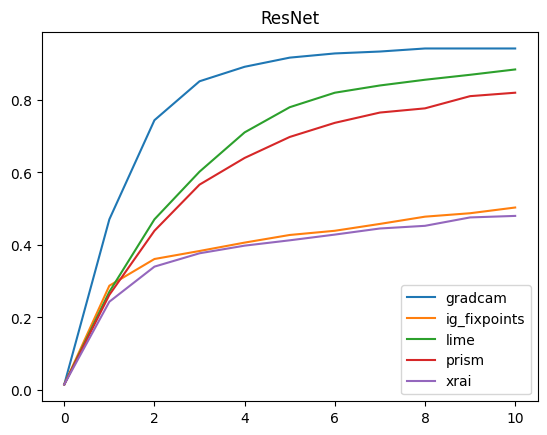

In [16]:
for entry in accuracies_all[2]:
    plt.plot(1-entry)
plt.legend(xai_methods)
plt.title('ResNet')
plt.show()

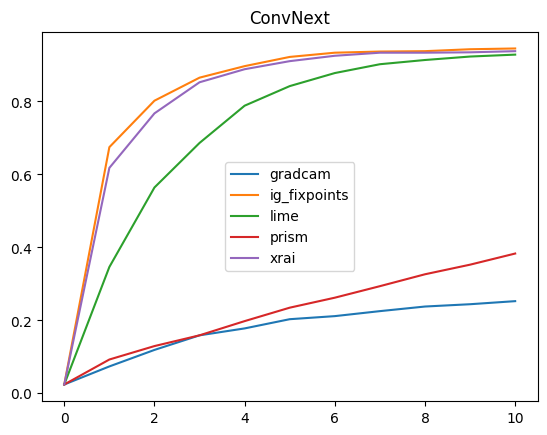

In [17]:
for entry in accuracies_all[3]:
    plt.plot(1-entry)
plt.legend(xai_methods)
plt.title('ConvNext')
plt.show()

In [18]:
print([x for x in accuracies_all[3]])

[array([0.97578947, 0.92631579, 0.88105263, 0.84105263, 0.82210526,
       0.79684211, 0.78842105, 0.77473684, 0.76210526, 0.75578947,
       0.74736842]), array([0.97578947, 0.32526316, 0.19789474, 0.13473684, 0.10315789,
       0.07789474, 0.06631579, 0.06315789, 0.06210526, 0.05684211,
       0.05473684]), array([0.97578947, 0.65368421, 0.43578947, 0.31368421, 0.21157895,
       0.15789474, 0.12210526, 0.09789474, 0.08631579, 0.07684211,
       0.07157895]), array([0.97578947, 0.90736842, 0.87052632, 0.84105263, 0.80210526,
       0.76526316, 0.73789474, 0.70631579, 0.67368421, 0.64736842,
       0.61684211]), array([0.97578947, 0.38210526, 0.23263158, 0.14736842, 0.11157895,
       0.08947368, 0.07473684, 0.06631579, 0.06631579, 0.06526316,
       0.06210526])]


NameError: name 'accuracies_all' is not defined

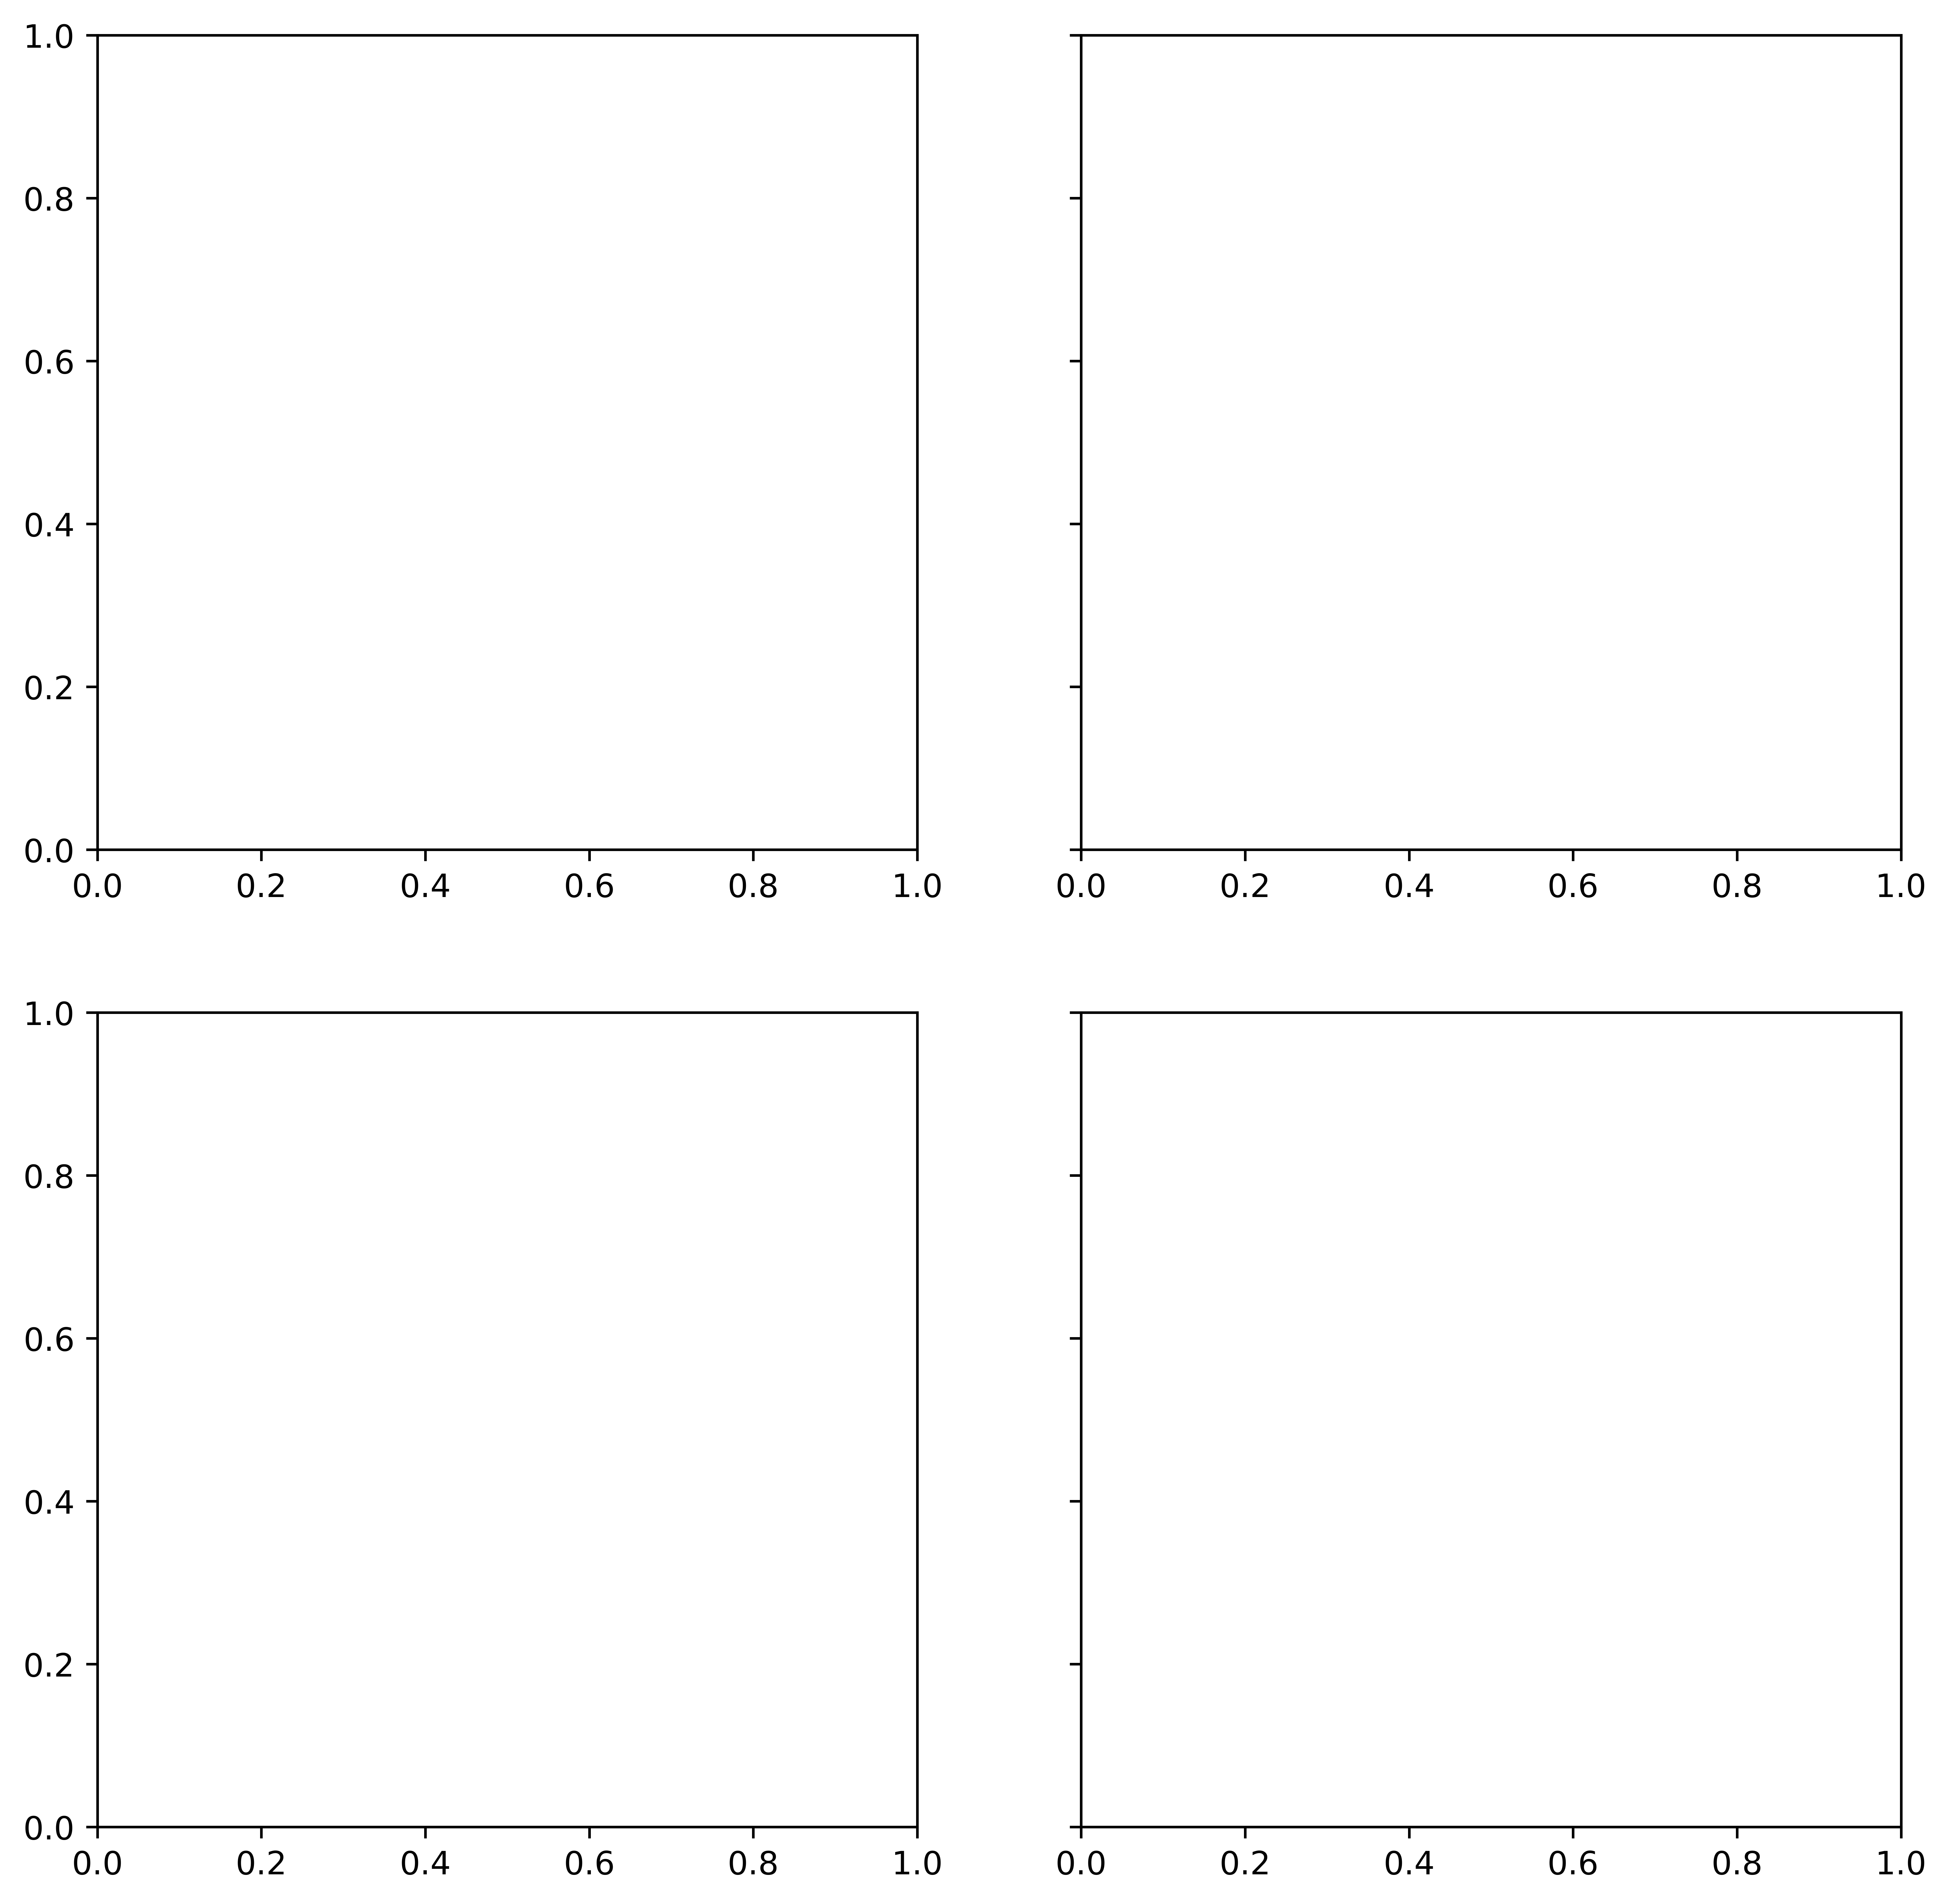

In [16]:
fig, ax = plt.subplots(2,2,figsize=(5,5),sharey=True,dpi=800)
for i in range(4):
    for entry in accuracies_all[i]:
        ax[i%2][i//2].plot(1-entry)
        ax[i%2][i//2].set_title(perf_tables_CNNs[i])
        ax[i%2][i//2].set_xticks([x for x in range(11)],[str(x) + "%" for x in range(11)])
        ax[i%2][i//2].set_yticks([0,0.2,0.4,0.6,0.8,1.0],[str(x) + "%" for x in range(0,101,20)])
        ax[i%2][i//2]

ax[1][0].legend(xai_methods)

fig.text(0.5,0.0,"Occluded Percentage", ha = 'center')
fig.text(0.0,0.5,"Test-Accuracy", ha = 'center', rotation='vertical')
plt.tight_layout()
plt.show()